In [1]:
import numpy as np
import PIL
import tensorflow as tf
import cv2

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import pathlib
import os
import matplotlib.pyplot as plt
import math
import pandas as pd
from tensorflow.keras.preprocessing import image_dataset_from_directory 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-04-11 12:46:44.571571: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#batch, image size, and directory
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
data_dir = "/Users/misscc/Desktop/2024Spring/Capstone_p/dataset"
data_dir = pathlib.Path(data_dir)

In [3]:
#splitting training and validation sets
train_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE,
  label_mode='categorical')

Found 24705 files belonging to 2 classes.
Using 19764 files for training.


In [4]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE,
  label_mode='categorical')

Found 24705 files belonging to 2 classes.
Using 4941 files for validation.


In [5]:
class_names = train_dataset.class_names
print(class_names)

['organic', 'recyclable']


In [6]:
#Define functions to get the number of images in each category to understand the distribution of the data set
def get_class_image_counts(dataset_directory, dataset_name, class_names, fraction):
    class_image_counts = {}
    for class_name in class_names:
        class_folder_path = os.path.join(dataset_directory, dataset_name, class_name)
        image_files = [file for file in os.listdir(class_folder_path) if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif'))]
        class_image_counts[class_name] = math.floor(len(image_files)*fraction)
    return class_image_counts 

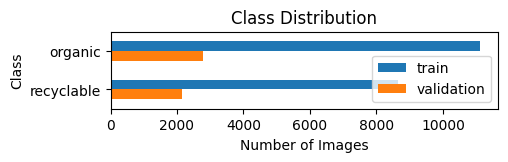

In [7]:
train_image_counts = get_class_image_counts(data_dir, '', class_names, .8)
val_image_counts = get_class_image_counts(data_dir, '', class_names, .2)

#Show the number of pictures for each category in the training set and validation set in tabular form.
df_train = pd.DataFrame(train_image_counts, index=['train']).T  
df_val = pd.DataFrame(val_image_counts, index=['validation']).T 
df_counts = pd.concat([df_train, df_val], axis=1)

#Using matplotlib
#Create a bar graph showing the distribution of the number of images for each category in the training set and the validation set
ax = df_counts.plot.barh(figsize=(5, 1))
ax.set_title('Class Distribution')
ax.set_xlabel('Number of Images')
ax.set_ylabel('Class')
ax.invert_yaxis()
plt.show()

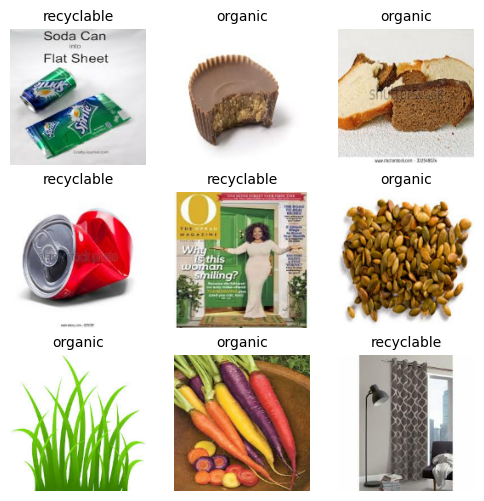

In [8]:
#Display a batch of picture samples from the training set with a 3x3 grid visualization structure.
plt.figure(figsize=(6, 6))
for images, labels in train_dataset.take(1):
  num_images_in_batch = images.shape[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.clip(images[i].numpy().astype("uint8"), 0, 255)) #plt.imshow(images[i].astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])], fontsize=10)
    plt.axis("off")

In [9]:
#Defines functions that sharpen and adjust the brightness of the input image
def sharpen_and_adjust_brightness(image):
    # Sharpen image
    image = image.astype('uint8')
    kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    sharpened = cv2.filter2D(image, -1, kernel)

    # Adjust brightness
    brightness_factor = np.random.uniform(0.5, 1.5)
    adjusted = cv2.convertScaleAbs(sharpened, alpha=1, beta=brightness_factor * 25)
    return adjusted

In [10]:
#Generate a data enhancer
train_datagen = ImageDataGenerator(
    preprocessing_function= sharpen_and_adjust_brightness,
    rotation_range=10, 
    width_shift_range=0.1, 
    height_shift_range=0.1,  
    shear_range=0.2,  
    zoom_range=0.2,  
    horizontal_flip=True,  
    fill_mode='nearest',
    validation_split=0.2,
    brightness_range=(0.8, 1.2) 
)

In [13]:
train_data_augmented = train_datagen.flow_from_directory(
    directory=str(data_dir),
    class_mode='categorical',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='training',
    seed=123
)

Found 19764 images belonging to 2 classes.


In [14]:
print(train_data_augmented.class_indices)

{'organic': 0, 'recyclable': 1}


In [12]:
validation_data_augmented = train_datagen.flow_from_directory(
    directory=str(data_dir),
    class_mode='categorical',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='validation', 
    seed=123
)

Found 4941 images belonging to 2 classes.


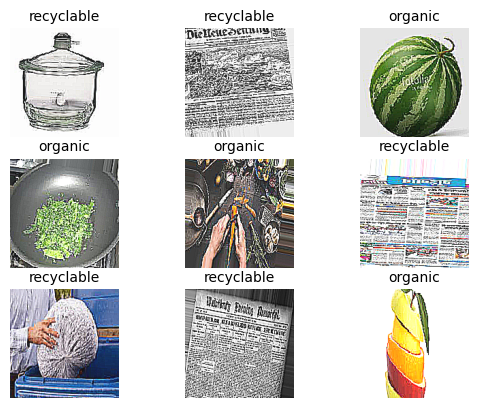

In [13]:
#Display a batch of picture samples from the augmented_training set with a 3x3 grid visualization structure.
augmented_images, augmented_labels = next(train_data_augmented)
for i in range(min(BATCH_SIZE, 9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i].astype("uint8"))
    plt.title(class_names[np.argmax(augmented_labels[i])], fontsize=10)
    plt.axis("off")

In [14]:
# #some built in data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [15]:
#MobileNet expects values from -1 to 1
#first we shift the values, then we normalize
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [16]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [17]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [18]:
#freeze MobileNet to fix the weights
base_model.trainable = False

In [19]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [20]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [21]:
prediction_layer = tf.keras.layers.Dense(len(class_names), activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 2)


In [22]:
#use functional API to add layers to the end of the Mobile net to predict the bird dataset/
#appropriate number of classes
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [23]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [25]:
initial_epochs = 5

In [27]:
history = model.fit(train_data_augmented,
                    epochs=initial_epochs,
                    validation_data=validation_data_augmented)

Epoch 1/5
170/618 [=======>......................] - ETA: 4:06 - loss: 0.3454 - accuracy: 0.8561

KeyboardInterrupt: 

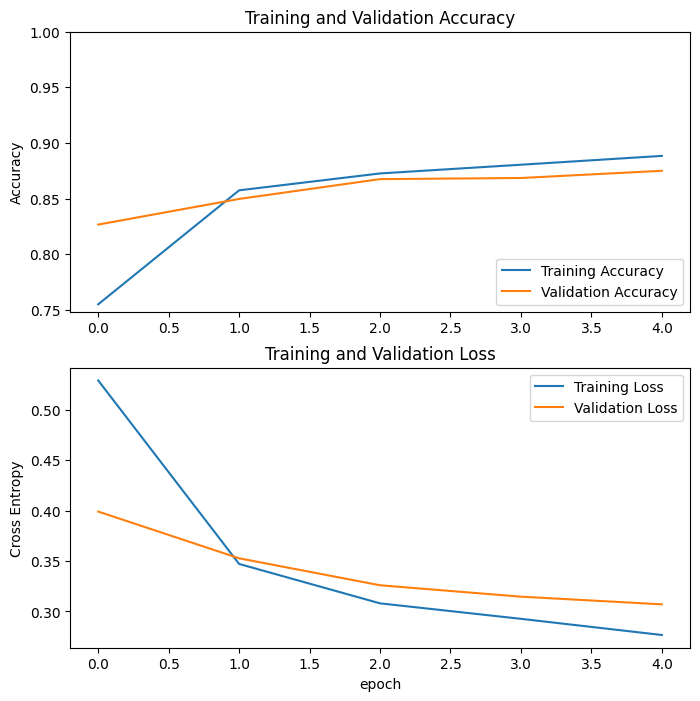

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#unfreezing to fine-tune model with our data
base_model.trainable = True

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, None   0         
                             )                                   
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                     

In [ ]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_data_augmented,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_data_augmented)

Epoch 5/10
618/618 [==============================] - 390s 630ms/step - loss: 0.2550 - accuracy: 0.9007 - val_loss: 0.2784 - val_accuracy: 0.8899
Epoch 6/10
618/618 [==============================] - 379s 613ms/step - loss: 0.2186 - accuracy: 0.9137 - val_loss: 0.2476 - val_accuracy: 0.9008
Epoch 7/10
618/618 [==============================] - 376s 608ms/step - loss: 0.1986 - accuracy: 0.9241 - val_loss: 0.2488 - val_accuracy: 0.9018
Epoch 8/10
618/618 [==============================] - 384s 622ms/step - loss: 0.1878 - accuracy: 0.9266 - val_loss: 0.2434 - val_accuracy: 0.9061
Epoch 9/10
618/618 [==============================] - 376s 608ms/step - loss: 0.1766 - accuracy: 0.9319 - val_loss: 0.2484 - val_accuracy: 0.9055
Epoch 10/10
618/618 [==============================] - 372s 601ms/step - loss: 0.1721 - accuracy: 0.9347 - val_loss: 0.2677 - val_accuracy: 0.8984


In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

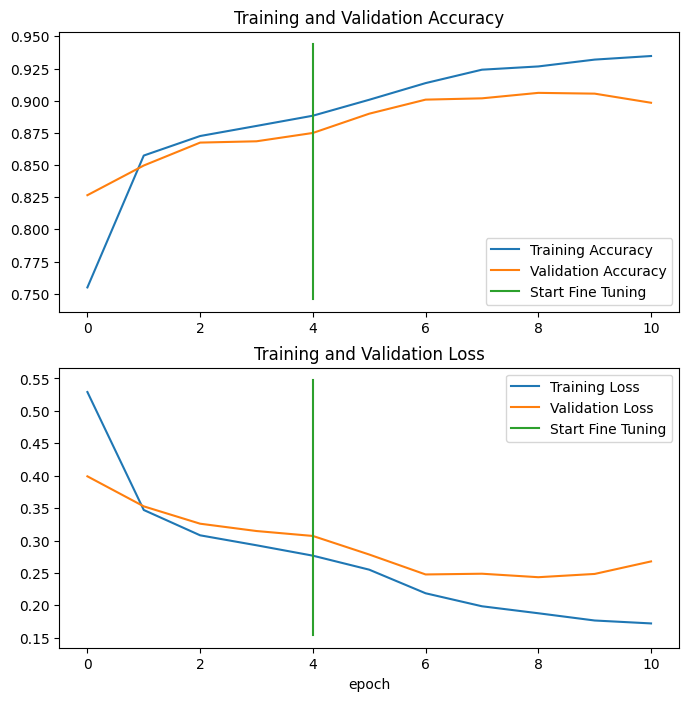

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
#plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
#plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Save model as savedmodel

In [28]:
model.save("mobilenet_model")

INFO:tensorflow:Assets written to: mobilenet_model/assets


INFO:tensorflow:Assets written to: mobilenet_model/assets
